<a href="https://colab.research.google.com/github/minolinesith/FYP/blob/Ensemble-Model/Ensemble_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading models


In [1]:
from google.colab import drive

# Connecting to google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

VGG16_model = load_model('/content/drive/MyDrive/FYP/Ensemble Model/LifeVeda_VGG16.keras')
ResNet50_model = load_model('/content/drive/MyDrive/FYP/Ensemble Model/LifeVeda_Resnet50.keras')
EfficientNetB5_model = load_model('/content/drive/MyDrive/FYP/Ensemble Model/LifeVeda_EfficientNetB5.keras')

# Loading Dataset

In [3]:
test_path = '/content/drive/MyDrive/Dataset-FYP/Dataset/test'

In [4]:
img_width = 224
img_height = 224

test_data = tf.keras.utils.image_dataset_from_directory(
    test_path,
    shuffle = False,
    image_size = (img_width, img_height),
    batch_size = 10,
    validation_split = False

)

Found 160 files belonging to 8 classes.


## Stacking


In [7]:
import numpy as np

In [8]:
X = []
Y = []
for images, labels in test_data:
    for image in images:
        X.append(image)
    for label in labels:
        Y.append(label)

In [9]:
y_train = np.array(Y)

In [10]:
vgg16_preds = VGG16_model.predict(test_data)

16/16 [==============================] - 15s 611ms/step


In [11]:
resnet50_preds = ResNet50_model.predict(test_data)

16/16 [==============================] - 17s 903ms/step


In [12]:
efficientNetB5_preds = EfficientNetB5_model.predict(test_data)

16/16 [==============================] - 16s 467ms/step


In [13]:
stacked_data_x = np.concatenate([vgg16_preds, resnet50_preds, efficientNetB5_preds])


In [14]:
stacked_data_y = np.concatenate([y_train,y_train,y_train])

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(stacked_data_x, stacked_data_y, test_size=0.2)

In [16]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x_train, y_train)

LogisticRegression()

In [17]:
score = LR.score(x_test, y_test)
print(round(score*100,2),'%')

90.62 %


In [18]:
predictions = LR.predict(x_test)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

Text(0.5, 1.0, 'Accuracy Score: 90.62')

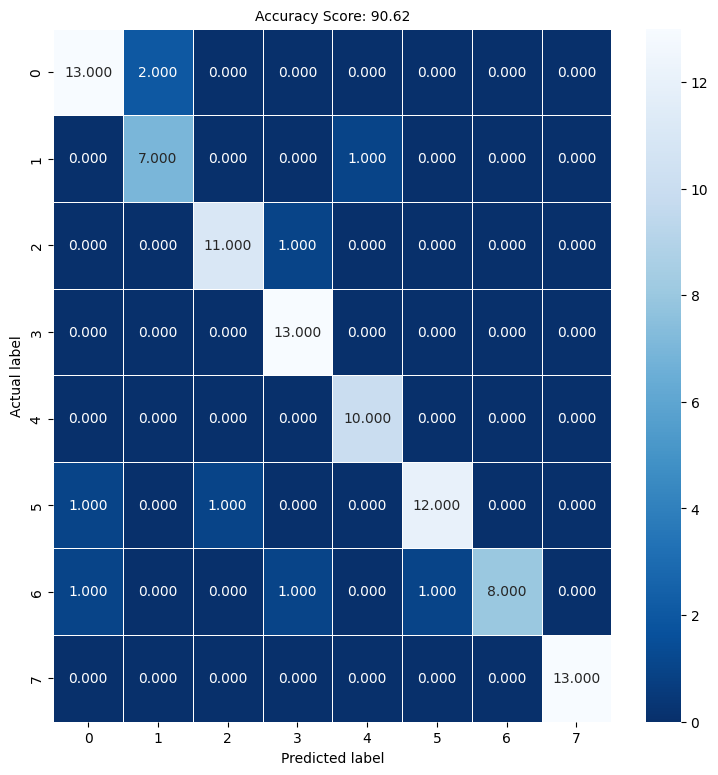

In [20]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score*100,2))
plt.title(all_sample_title, size = 10)

# Weighted Average

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [22]:
train_path = '/content/drive/MyDrive/Dataset-FYP/Dataset/train'
valid_path = '/content/drive/MyDrive/Dataset-FYP/Dataset/validation'
test_path = '/content/drive/MyDrive/Dataset-FYP/Dataset/test'

In [23]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle = True,
    image_size = (img_width, img_height),
    batch_size = 10,
    validation_split = False,
)

valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    shuffle = False,
    image_size = (img_width, img_height),
    batch_size = 10,
    validation_split = False

)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_path,
    shuffle = False,
    image_size = (img_width, img_height),
    batch_size = 10,
    validation_split = False

)

Found 1601 files belonging to 8 classes.
Found 480 files belonging to 8 classes.
Found 160 files belonging to 8 classes.


In [24]:
from tensorflow.keras.layers import Average

models = [VGG16_model, ResNet50_model, EfficientNetB5_model]

for model in models:
  for layer in model.layers:
      layer.trainable = False

In [25]:
def weighted_average(w1,w2,w3,inputs):
    return w1 * inputs[0] + w2 * inputs[1] + w3 * inputs[2]

In [26]:
model_input = keras.Input(shape=(img_width,img_height,3))
models_output=[model(model_input) for model in models]
weighted_average_output=weighted_average(0.1,0.3,0.6,models_output)
ensemble_model_weighted_avg=keras.Model(inputs=model_input,outputs=weighted_average_output)


In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True )

In [28]:
ensemble_model_weighted_avg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [29]:
epochs = 10
history = ensemble_model_weighted_avg.fit(train_data, validation_data = valid_data, epochs = epochs, callbacks=[callback])

Epoch 1/10
161/161 [==============================] - 548s 3s/step - loss: 0.0167 - accuracy: 0.9875 - val_loss: 1.1700e-06 - val_accuracy: 1.0000
Epoch 2/10
161/161 [==============================] - 112s 672ms/step - loss: 0.0145 - accuracy: 0.9888 - val_loss: 1.1700e-06 - val_accuracy: 1.0000
Epoch 3/10
161/161 [==============================] - 109s 652ms/step - loss: 0.0134 - accuracy: 0.9888 - val_loss: 1.1700e-06 - val_accuracy: 1.0000
Epoch 4/10
161/161 [==============================] - 109s 650ms/step - loss: 0.0100 - accuracy: 0.9925 - val_loss: 1.1700e-06 - val_accuracy: 1.0000


In [30]:
ensemble_test_loss_wa, ensemble_test_accuracy_wa = ensemble_model_weighted_avg.evaluate(test_data)

print(f'Test Accuracy: {ensemble_test_accuracy_wa * 100:.2f}%')

16/16 [==============================] - 9s 503ms/step - loss: 0.1068 - accuracy: 0.9688
Test Accuracy: 96.88%


# Average

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [32]:
from tensorflow.keras.layers import Average

models = [VGG16_model, ResNet50_model, EfficientNetB5_model]

for model in models:
  for layer in model.layers:
      layer.trainable = False

In [33]:
model_input = keras.Input(shape=(img_width,img_height,3))
models_output=[model(model_input) for model in models]
average_output=layers.Average()(models_output)
ensemble_model_average=keras.Model(inputs=model_input,outputs=average_output)


In [34]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True )

In [35]:
ensemble_model_average.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [36]:
epochs = 10
history = ensemble_model_average.fit(train_data, validation_data = valid_data, epochs = epochs, callbacks=[callback])

Epoch 1/10
161/161 [==============================] - 129s 657ms/step - loss: 0.0130 - accuracy: 0.9994 - val_loss: 1.3535e-06 - val_accuracy: 1.0000
Epoch 2/10
161/161 [==============================] - 107s 640ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.3535e-06 - val_accuracy: 1.0000
Epoch 3/10
161/161 [==============================] - 106s 634ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 1.3535e-06 - val_accuracy: 1.0000
Epoch 4/10
161/161 [==============================] - 107s 643ms/step - loss: 0.0100 - accuracy: 0.9994 - val_loss: 1.3535e-06 - val_accuracy: 1.0000


In [37]:
ensemble_avg_test_loss, ensemble_avg_test_accuracy = ensemble_model_average.evaluate(test_data)

print(f'Test Accuracy: {ensemble_avg_test_accuracy * 100:.2f}%')

16/16 [==============================] - 9s 536ms/step - loss: 0.1555 - accuracy: 0.9625
Test Accuracy: 96.25%
